## Global Black Box Optimization with RNNS

In [1]:
import tensorflow as tf
import numpy as np
import visualize as viz
import benchmarkfunctions as bf
import gpfunctions as gp
import lstm_model
import data

In [2]:
def print_model():
        print("Function Dimension: \t\t"+str(dim))
        print("Number of Training Samples: \t"+str(n_train))
        print("Number of Test Samples: \t"+str(n_test))
        print("Number of GP-Bumps: \t\t"+str(n_bumps))
        print("GP length scale: \t\t"+str(l))     
        print("Number of hidden Units: \t"+str(n_hidden))
        print("Sequence length: \t\t"+ str(n_steps))
        print("Noise in Observation: \t\t"+ str(stddev))
        print("Loss-Function: \t\t\t" + loss_type)
        print("Epochs: \t\t\t"+str(epochs))
        print("Gradient clipping: \t\t"+str(gradient_clipping))
        print("Forget bias: \t\t\t"+str(forget_bias))
        print("Batch size: \t\t\t"+str(batch_size))
        print("Learning rate init: \t\t"+str(rate_init))
        print("Learning rate final: \t\t"+str(rate_final))
        print("Learning rate decay: \t\t"+str(rate_decay))
        print("------------------------------------------------------------------------------------")

In [3]:
# Data
dim = 2
n_train = 1600
n_test = 160
n_bumps = 6
l = 2/n_bumps*np.sqrt(dim)
n_mc_samples = 1000

# LSTM Model
n_hidden = 100
n_steps = 20

# Optimization
epochs = 100
gradient_clipping = 5.0
forget_bias = 5.0
rate_init = 0.005
rate_final = 0.0001
rate_decay = (rate_final/rate_init)**(1/epochs)
batch_size = 128
stddev = 0.00
loss_type = ["MIN", "SUM", "WSUM", "EI", "SUMMIN"][1]

# Visualization
visualize = False

In [4]:
X_train, A_train, min_train, max_train, X_test, A_test, min_test, max_test = \
                                    data.gen_data(n_train, n_test, dim, n_bumps, l, n_mc_samples)
    
data_train = (X_train, A_train, min_train, max_train)
data_test = (X_test, A_test, min_test, max_test)

In [5]:
# Visualize Training Data
if visualize:
    nplot = 9
    idx = np.random.choice(list(range(n_train)), nplot)
    f_plot = lambda x: gp.normalize(min_train[idx], max_train[idx], gp.GP(X_train[idx], A_train[idx], x, l)) 
    viz.plot_training_data(f_plot, dim, nplot, heat = True)

In [6]:
Xt, At, mint, maxt, samples_x, samples_y, cell, weights = \
        lstm_model.build_training_graph(n_bumps, dim, n_hidden, forget_bias, n_steps, l)
    
placeholders = {"Xt": Xt, "At": At, "mint": mint, "maxt": maxt}

In [7]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [ ]:
train_logs = lstm_model.train_model(sess, placeholders, samples_y, epochs, batch_size, data_train, data_test,
                     rate_init, rate_decay, gradient_clipping, loss_type,  log = True)

In [ ]:
viz.visualize_learning(train_logs)

## Evaluate on Training/Test Data

In [ ]:
# Extract Samples
samples_train_x, samples_train_y = sess.run([samples_x, samples_y],\
                                            feed_dict={Xt: X_train, At: A_train, mint: min_train, maxt: max_train})
samples_train_x = np.array(samples_train_x).reshape(n_steps+1,n_train, dim).transpose((1,0,2))
samples_train_y = np.array(samples_train_y).reshape(n_steps+1,n_train).T
samples_test_x, samples_test_y = sess.run([samples_x, samples_y],\
                                          feed_dict={Xt: X_test, At: A_test, mint: min_test, maxt: max_test})
samples_test_x = np.array(samples_test_x).reshape(n_steps+1,n_test, dim).transpose((1,0,2))
samples_test_y = np.array(samples_test_y).reshape(n_steps+1,n_test).T

In [ ]:
# Show results on Training Data
if visualize:
    nplot = 12
    idx = np.random.choice(list(range(n_train)), nplot)
    f_plot = lambda x: normalize(min_train[idx], max_train[idx], GP(X_train[idx], A_train[idx], x)) 
    viz.plot_result(f_plot, dim, nplot, samples_train_x[idx], samples_train_y[idx])

In [ ]:
# Show results on Test Data
if visualize:
    nplot = 12
    idx = np.random.choice(list(range(n_test)), nplot)
    f_plot = lambda x: normalize(min_test[idx], max_test[idx], GP(X_test[idx], A_test[idx], x)) 
    viz.plot_result(f_plot, dim, nplot, samples_test_x[idx], samples_test_y[idx])

## Evaluate on Benchmark Function

In [8]:
f_bm = [bf.branin, bf.goldstein_price, bf.hartmann3, bf.hartmann6][1]
f_bm_tf = [bf.branin_tf, bf.goldstein_price_tf, bf.hartmann3_tf, bf.hartmann6_tf][1]

In [10]:
samples_benchmark_x, samples_benchmark_y = sess.run(lstm_model.apply_lstm_model(f_bm_tf, cell, weights, n_steps, dim, n_hidden, 1))
# sess.run(lstm_model(f_bm_tf, cell, weights), feed_dict={size: 1})
samples_benchmark_x = np.array(samples_benchmark_x).reshape(n_steps+1,1, dim).transpose((1,0,2))
samples_benchmark_y = np.array(samples_benchmark_y).reshape(n_steps+1,1).T

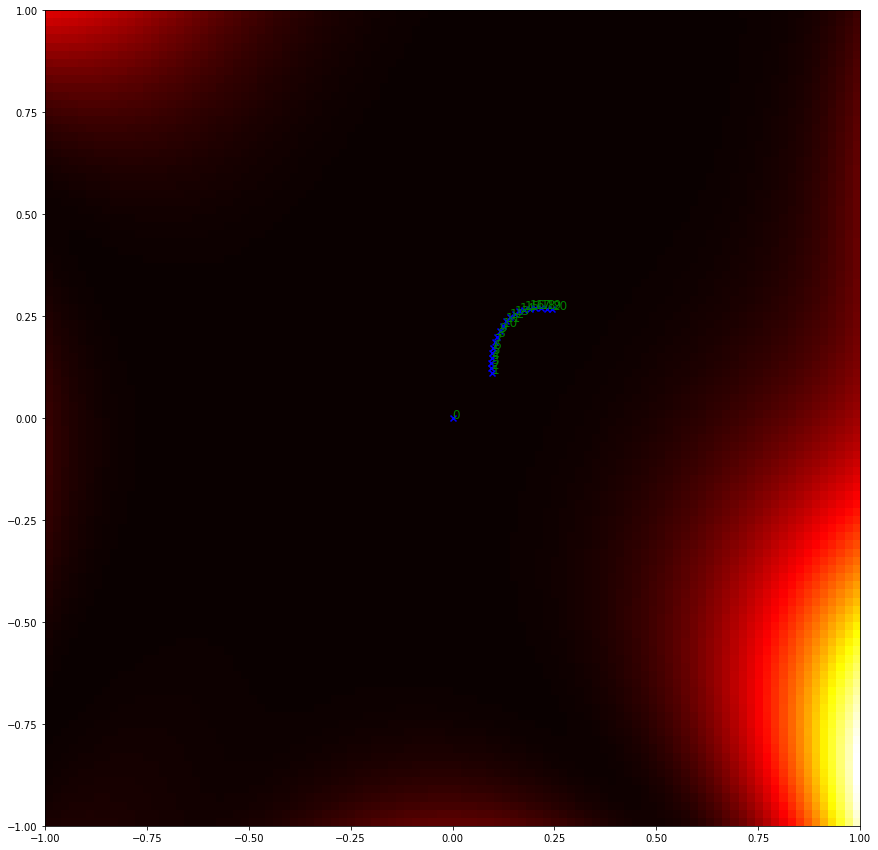

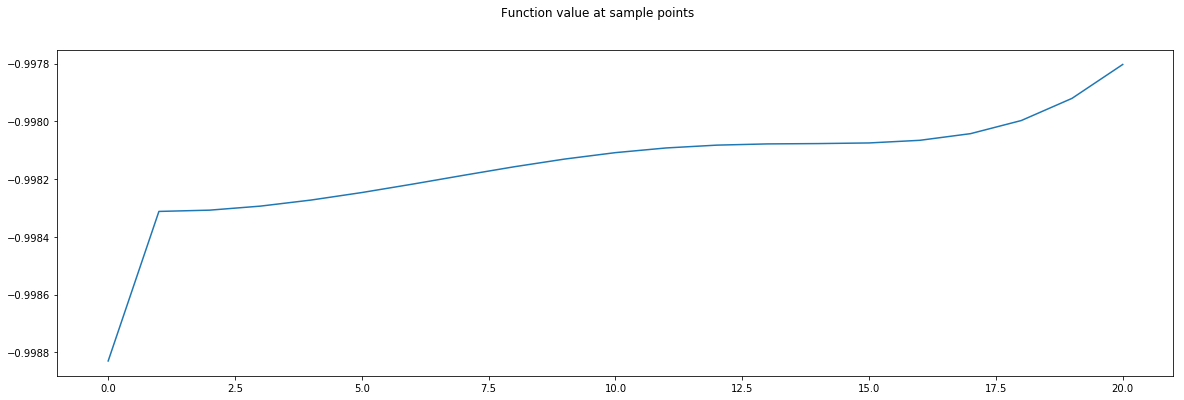

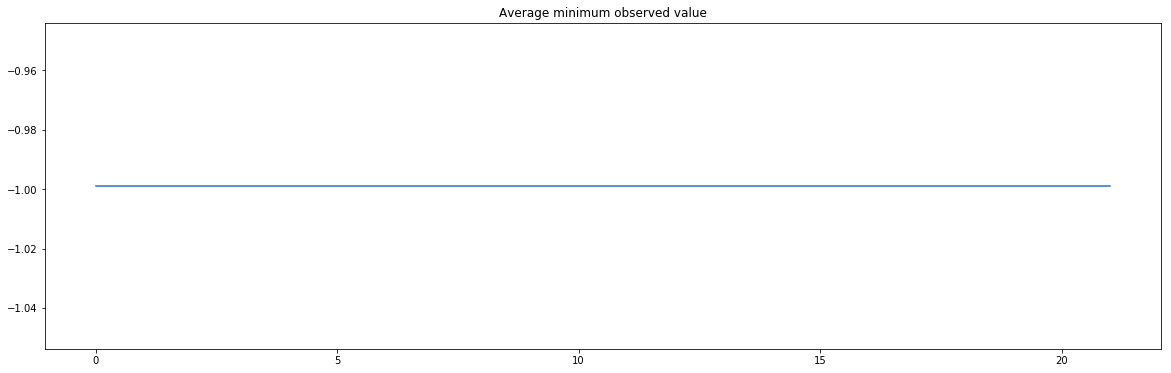

In [11]:
viz.plot_result(f_bm, dim, 1, samples_benchmark_x, samples_benchmark_y)